##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow の NumPy API

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/tf_numpy"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/tf_numpy.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/tf_numpy.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/tf_numpy.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

## 概要

TensorFlow では、<code>tf.experimental.numpy</code>を利用して<a>NumPy API</a> のサブセットを実装します。これにより、TensorFlow により高速化された NumPy コードを実行し、TensorFlow のすべて API にもアクセスできます。

## セットアップ


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import timeit

print("Using TensorFlow version %s" % tf.__version__)

2024-01-11 18:47:12.854741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 18:47:12.854782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 18:47:12.856314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow version 2.15.0


### NumPy 動作の有効化

`tnp` を NumPy として使用するには、TensorFlow の NumPy の動作を有効にしてください。

In [3]:
tnp.experimental_enable_numpy_behavior()

この呼び出しによって、TensorFlow での型昇格が可能になり、リテラルからテンソルに変換される場合に、型推論も Numpy の標準により厳格に従うように変更されます。

注意: この呼び出しは、`tf.experimental.numpy` モジュールだけでなく、TensorFlow 全体の動作を変更します。

## TensorFlow NumPy ND 配列

**ND 配列**と呼ばれる `tf.experimental.numpy.ndarray` は、特定のデバイスに配置されたある `dtype` の多次元の密な配列を表します。`tf.Tensor` のエイリアスです。`ndarray.T`、`ndarray.reshape`、`ndarray.ravel` などの便利なメソッドについては、ND 配列クラスをご覧ください。

まず、ND 配列オブジェクトを作成してから、さまざまなメソッドを呼び出します。

In [4]:
# Create an ND array and check out different attributes.
ones = tnp.ones([5, 3], dtype=tnp.float32)
print("Created ND array with shape = %s, rank = %s, "
      "dtype = %s on device = %s\n" % (
          ones.shape, ones.ndim, ones.dtype, ones.device))

# `ndarray` is just an alias to `tf.Tensor`.
print("Is `ones` an instance of tf.Tensor: %s\n" % isinstance(ones, tf.Tensor))

# Try commonly used member functions.
print("ndarray.T has shape %s" % str(ones.T.shape))
print("narray.reshape(-1) has shape %s" % ones.reshape(-1).shape)

Created ND array with shape = (5, 3), rank = 2, dtype = <dtype: 'float32'> on device = /job:localhost/replica:0/task:0/device:GPU:0

Is `ones` an instance of tf.Tensor: True

ndarray.T has shape (3, 5)
narray.reshape(-1) has shape (15,)


### 型昇格

TensorFlow の型昇格には 4 つのオプションがあります。

- デフォルトでは、混合型の演算に対し、TensorFlow は型を昇格する代わりにエラーを発します。
- `tf.numpy.experimental_enable_numpy_behavior()` を実行すると、`NumPy` 型の昇格ルール（以下に説明）を使うように TensorFlow が切り替えられます。
- TensorFlow 2.15 以降で使用できる以下の新しいオプションが 2 つあります（詳細は、[TF NumPy 型昇格](tf_numpy_type_promotion.ipynb)をご覧ください）。
    - `tf.numpy.experimental_enable_numpy_behavior(dtype_conversion_mode="all")` は、Jax の型昇格ルールを使用します。
    - `tf.numpy.experimental_enable_numpy_behavior(dtype_conversion_mode="safe")` は Jax の型昇格ルールを使用しますが、特定の安全でない昇格を許可しません。

#### NumPy 型昇格

TensorFlow NumPy API には、リテラルを ND 配列に変換するためと ND 配列入力で型昇格を実行するための明確に定義されたセマンティクスがあります。詳細については、[`np.result_type`](https://numpy.org/doc/1.16/reference/generated/numpy.result_type.html) をご覧ください。

TensorFlow API は `tf.Tensor` 入力を変更せずそのままにし、それに対して型昇格を実行しませんが、TensorFlow NumPy API は NumPy 型昇格のルールに従って、すべての入力を昇格します。次の例では、型昇格を行います。まず、さまざまな型の ND 配列入力で加算を実行し、出力の型を確認します。これらの型昇格は、TensorFlow API では行えません。

In [5]:
print("Type promotion for operations")
values = [tnp.asarray(1, dtype=d) for d in
          (tnp.int32, tnp.int64, tnp.float32, tnp.float64)]
for i, v1 in enumerate(values):
  for v2 in values[i + 1:]:
    print("%s + %s => %s" %
          (v1.dtype.name, v2.dtype.name, (v1 + v2).dtype.name))

Type promotion for operations
int32 + int64 => int64
int32 + float32 => float64
int32 + float64 => float64
int64 + float32 => float64
int64 + float64 => float64
float32 + float64 => float64


最後に、`ndarray.asarray` を使ってリテラルをND 配列に変換し、結果の型を確認します。

In [6]:
print("Type inference during array creation")
print("tnp.asarray(1).dtype == tnp.%s" % tnp.asarray(1).dtype.name)
print("tnp.asarray(1.).dtype == tnp.%s\n" % tnp.asarray(1.).dtype.name)

Type inference during array creation
tnp.asarray(1).dtype == tnp.int64
tnp.asarray(1.).dtype == tnp.float64



リテラルを ND 配列に変換する際、NumPy は `tnp.int64` や `tnp.float64` といった幅広い型を優先します。一方、`tf.convert_to_tensor` は、`tf.int32` と `tf.float32` の型を優先して定数を `tf.Tensor` に変換します。TensorFlow NumPy API は、整数に関しては NumPy の動作に従っています。浮動小数点数については、`experimental_enable_numpy_behavior` の `prefer_float32` 引数によって、`tf.float64` よりも `tf.float32` を優先するかどうかを制御することができます（デフォルトは `False` です）。以下に例を示します。

In [7]:
tnp.experimental_enable_numpy_behavior(prefer_float32=True)
print("When prefer_float32 is True:")
print("tnp.asarray(1.).dtype == tnp.%s" % tnp.asarray(1.).dtype.name)
print("tnp.add(1., 2.).dtype == tnp.%s" % tnp.add(1., 2.).dtype.name)

tnp.experimental_enable_numpy_behavior(prefer_float32=False)
print("When prefer_float32 is False:")
print("tnp.asarray(1.).dtype == tnp.%s" % tnp.asarray(1.).dtype.name)
print("tnp.add(1., 2.).dtype == tnp.%s" % tnp.add(1., 2.).dtype.name)

When prefer_float32 is True:
tnp.asarray(1.).dtype == tnp.float32
tnp.add(1., 2.).dtype == tnp.float32
When prefer_float32 is False:
tnp.asarray(1.).dtype == tnp.float64
tnp.add(1., 2.).dtype == tnp.float64


### ブロードキャスト

TensorFlow と同様に、NumPy は「ブロードキャスト」値の豊富なセマンティクスを定義します。詳細については、[NumPy ブロードキャストガイド](https://numpy.org/doc/stable/user/basics.broadcasting.html)を確認し、これを [TensorFlow ブロードキャストセマンティクス](https://www.tensorflow.org/guide/tensor#broadcasting)と比較してください。

In [8]:
x = tnp.ones([2, 3])
y = tnp.ones([3])
z = tnp.ones([1, 2, 1])
print("Broadcasting shapes %s, %s and %s gives shape %s" % (
    x.shape, y.shape, z.shape, (x + y + z).shape))

Broadcasting shapes (2, 3), (3,) and (1, 2, 1) gives shape (1, 2, 3)


### インデックス作成

NumPy は、非常に洗練されたインデックス作成ルールを定義しています。[NumPy インデックスガイド](https://numpy.org/doc/stable/reference/arrays.indexing.html)を参照してください。以下では、インデックスとして ND 配列が使用されていることに注意してください。

In [9]:
x = tnp.arange(24).reshape(2, 3, 4)

print("Basic indexing")
print(x[1, tnp.newaxis, 1:3, ...], "\n")

print("Boolean indexing")
print(x[:, (True, False, True)], "\n")

print("Advanced indexing")
print(x[1, (0, 0, 1), tnp.asarray([0, 1, 1])])

Basic indexing
tf.Tensor(
[[[16 17 18 19]
  [20 21 22 23]]], shape=(1, 2, 4), dtype=int64) 

Boolean indexing


tf.Tensor(
[[[ 0  1  2  3]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [20 21 22 23]]], shape=(2, 2, 4), dtype=int64) 

Advanced indexing
tf.Tensor([12 13 17], shape=(3,), dtype=int64)


In [10]:
# Mutation is currently not supported
try:
  tnp.arange(6)[1] = -1
except TypeError:
  print("Currently, TensorFlow NumPy does not support mutation.")

Currently, TensorFlow NumPy does not support mutation.


### サンプルモデル

次に、モデルを作成して推論を実行する方法を見てみます。この簡単なモデルは、relu レイヤーとそれに続く線形射影を適用します。後のセクションでは、TensorFlow の`GradientTape`を使用してこのモデルの勾配を計算する方法を示します。

In [11]:
class Model(object):
  """Model with a dense and a linear layer."""

  def __init__(self):
    self.weights = None

  def predict(self, inputs):
    if self.weights is None:
      size = inputs.shape[1]
      # Note that type `tnp.float32` is used for performance.
      stddev = tnp.sqrt(size).astype(tnp.float32)
      w1 = tnp.random.randn(size, 64).astype(tnp.float32) / stddev
      bias = tnp.random.randn(64).astype(tnp.float32)
      w2 = tnp.random.randn(64, 2).astype(tnp.float32) / 8
      self.weights = (w1, bias, w2)
    else:
      w1, bias, w2 = self.weights
    y = tnp.matmul(inputs, w1) + bias
    y = tnp.maximum(y, 0)  # Relu
    return tnp.matmul(y, w2)  # Linear projection

model = Model()
# Create input data and compute predictions.
print(model.predict(tnp.ones([2, 32], dtype=tnp.float32)))

tf.Tensor(
[[-1.5633821  0.1619502]
 [-1.5633821  0.1619502]], shape=(2, 2), dtype=float32)


## TensorFlow NumPy および NumPy

TensorFlow NumPy は、完全な NumPy 仕様のサブセットを実装します。シンボルは、今後追加される予定ですが、近い将来にサポートされなくなる体系的な機能があります。これらには、NumPy C API サポート、Swig 統合、Fortran ストレージ優先順位、ビュー、`stride_tricks`、およびいくつかの`dtype`（`np.recarray`や<code> np.object</code>）が含まれます。詳細については、 <a>TensorFlow NumPy API ドキュメント</a>をご覧ください。


### NumPy 相互運用性

TensorFlow ND 配列は、NumPy 関数と相互運用できます。これらのオブジェクトは、`__array__`インターフェースを実装します。NumPy はこのインターフェースを使用して、関数の引数を処理する前に`np.ndarray`値に変換します。

同様に、TensorFlow NumPy 関数は、`np.ndarray` などのさまざまなタイプの入力を受け入れることができます。これらの入力は、<code>ndarray.asarray</code> を呼び出すことにより、ND 配列に変換されます。

ND 配列を`np.ndarray`との間で変換すると、実際のデータコピーがトリガーされる場合があります。詳細については、[バッファコピー](#Buffer-copies)のセクションを参照してください。

In [12]:
# ND array passed into NumPy function.
np_sum = np.sum(tnp.ones([2, 3]))
print("sum = %s. Class: %s" % (float(np_sum), np_sum.__class__))

# `np.ndarray` passed into TensorFlow NumPy function.
tnp_sum = tnp.sum(np.ones([2, 3]))
print("sum = %s. Class: %s" % (float(tnp_sum), tnp_sum.__class__))

sum = 6.0. Class: <class 'numpy.float64'>
sum = 6.0. Class: <class 'tensorflow.python.framework.ops.EagerTensor'>


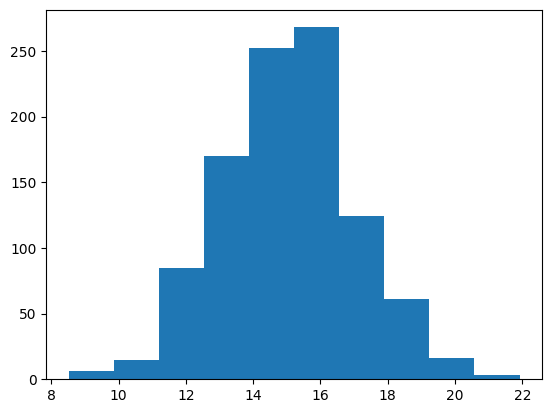

In [13]:
# It is easy to plot ND arrays, given the __array__ interface.
labels = 15 + 2 * tnp.random.randn(1, 1000)
_ = plt.hist(labels)

### バッファコピー

TensorFlow NumPy を NumPy コードと混在させると、データコピーがトリガーされる場合があります。これは、TensorFlow NumPy のメモリアライメントに関する要件が NumPy の要件よりも厳しいためです。

`np.ndarray`が TensorFlow Numpy に渡されると、アライメント要件を確認し、必要に応じてコピーがトリガーされます。ND 配列 CPU バッファを NumPy に渡す場合、通常、バッファはアライメント要件を満たし、NumPy はコピーを作成する必要はありません。

ND 配列は、ローカル CPU メモリ以外のデバイスに配置されたバッファを参照できます。このような場合、NumPy 関数を呼び出すと、必要に応じてネットワークまたはデバイス全体でコピーが作成されます。

このため、NumPy API 呼び出しとの混合は通常、注意して行い、ユーザーはデータのコピーのオーバーヘッドに注意する必要があります。TensorFlow NumPy 呼び出しを TensorFlow 呼び出しとインターリーブすることは一般的に安全であり、データのコピーを避けられます。 詳細については、[TensorFlow の相互運用性](#tensorflow-interoperability)のセクションをご覧ください。

### 演算子の優先順位

TensorFlow NumPy は、NumPy よりも優先順位の高い`__array_priority__`を定義します。つまり、ND 配列と`np.ndarray`の両方を含む演算子の場合、前者が優先されます。`np.ndarray`入力は ND 配列に変換され、演算子の TensorFlow NumPy 実装が呼び出されます。

In [14]:
x = tnp.ones([2]) + np.ones([2])
print("x = %s\nclass = %s" % (x, x.__class__))

x = tf.Tensor([2. 2.], shape=(2,), dtype=float64)
class = <class 'tensorflow.python.framework.ops.EagerTensor'>


## TF NumPy と TensorFlow

TensorFlow NumPy は TensorFlow の上に構築されているため、TensorFlow とシームレスに相互運用できます。

### `tf.Tensor` と ND 配列

ND 配列は `tf.Tensor` のエイリアスであるため、実際のデータのコピーを呼び出さずに混在させることが可能です。

In [15]:
x = tf.constant([1, 2])
print(x)

# `asarray` and `convert_to_tensor` here are no-ops.
tnp_x = tnp.asarray(x)
print(tnp_x)
print(tf.convert_to_tensor(tnp_x))

# Note that tf.Tensor.numpy() will continue to return `np.ndarray`.
print(x.numpy(), x.numpy().__class__)

tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([1 2], shape=(2,), dtype=int32)
[1 2] <class 'numpy.ndarray'>


### TensorFlow 相互運用性

ND 配列は `tf.Tensor` のエイリアスにすぎないため、TensorFlow API に渡すことができます。前述のように、このような相互運用では、アクセラレータやリモートデバイスに配置されたデータであっても、データのコピーは行われません。

逆に言えば、`tf.Tensor` オブジェクトを、データのコピーを実行せずに、`tf.experimental.numpy` API に渡すことができます。

In [16]:
# ND array passed into TensorFlow function.
tf_sum = tf.reduce_sum(tnp.ones([2, 3], tnp.float32))
print("Output = %s" % tf_sum)

# `tf.Tensor` passed into TensorFlow NumPy function.
tnp_sum = tnp.sum(tf.ones([2, 3]))
print("Output = %s" % tnp_sum)

Output = tf.Tensor(6.0, shape=(), dtype=float32)
Output = tf.Tensor(6.0, shape=(), dtype=float32)


### 勾配とヤコビアン: tf.GradientTape

TensorFlow の GradientTape は、TensorFlow と TensorFlow NumPy コードを介してバックプロパゲーションに使用できます。

[サンプルモデル](#example-model)セクションで作成されたモデルを使用して、勾配とヤコビアンを計算します。

In [17]:
def create_batch(batch_size=32):
  """Creates a batch of input and labels."""
  return (tnp.random.randn(batch_size, 32).astype(tnp.float32),
          tnp.random.randn(batch_size, 2).astype(tnp.float32))

def compute_gradients(model, inputs, labels):
  """Computes gradients of squared loss between model prediction and labels."""
  with tf.GradientTape() as tape:
    assert model.weights is not None
    # Note that `model.weights` need to be explicitly watched since they
    # are not tf.Variables.
    tape.watch(model.weights)
    # Compute prediction and loss
    prediction = model.predict(inputs)
    loss = tnp.sum(tnp.square(prediction - labels))
  # This call computes the gradient through the computation above.
  return tape.gradient(loss, model.weights)

inputs, labels = create_batch()
gradients = compute_gradients(model, inputs, labels)

# Inspect the shapes of returned gradients to verify they match the
# parameter shapes.
print("Parameter shapes:", [w.shape for w in model.weights])
print("Gradient shapes:", [g.shape for g in gradients])
# Verify that gradients are of type ND array.
assert isinstance(gradients[0], tnp.ndarray)

Parameter shapes: [TensorShape([32, 64]), TensorShape([64]), TensorShape([64, 2])]
Gradient shapes: [TensorShape([32, 64]), TensorShape([64]), TensorShape([64, 2])]


In [18]:
# Computes a batch of jacobians. Each row is the jacobian of an element in the
# batch of outputs w.r.t. the corresponding input batch element.
def prediction_batch_jacobian(inputs):
  with tf.GradientTape() as tape:
    tape.watch(inputs)
    prediction = model.predict(inputs)
  return prediction, tape.batch_jacobian(prediction, inputs)

inp_batch = tnp.ones([16, 32], tnp.float32)
output, batch_jacobian = prediction_batch_jacobian(inp_batch)
# Note how the batch jacobian shape relates to the input and output shapes.
print("Output shape: %s, input shape: %s" % (output.shape, inp_batch.shape))
print("Batch jacobian shape:", batch_jacobian.shape)

Output shape: (16, 2), input shape: (16, 32)
Batch jacobian shape: (16, 2, 32)


### トレースコンパイル: tf.function

Tensorflow の `tf.function` は、コードを「トレースコンパイル」し、これらのトレースを最適化してパフォーマンスを大幅に向上させます。[グラフと関数の概要](./intro_to_graphs.ipynb)を参照してください。

また、`tf.function` を使用して、TensorFlow NumPy コードを最適化することもできます。以下は、スピードアップを示す簡単な例です。`tf.function` コードの本文には、TensorFlow NumPy API への呼び出しが含まれていることに注意してください。


In [19]:
inputs, labels = create_batch(512)
print("Eager performance")
compute_gradients(model, inputs, labels)
print(timeit.timeit(lambda: compute_gradients(model, inputs, labels),
                    number=10) * 100, "ms")

print("\ntf.function compiled performance")
compiled_compute_gradients = tf.function(compute_gradients)
compiled_compute_gradients(model, inputs, labels)  # warmup
print(timeit.timeit(lambda: compiled_compute_gradients(model, inputs, labels),
                    number=10) * 100, "ms")

Eager performance


2.6766205000058108 ms

tf.function compiled performance


0.7275895000020682 ms


### ベクトル化：tf.vectorized_map

TensorFlow には、並列ループのベクトル化のサポートが組み込まれているため、10 倍から 100 倍のスピードアップが可能です。これらのスピードアップは、`tf.vectorized_map` API を介して実行でき、TensorFlow NumPy にも適用されます。

w.r.t. （対応する入力バッチ要素）バッチで各出力の勾配を計算すると便利な場合があります。このような計算は、以下に示すように `tf.vectorized_map` を使用して効率的に実行できます。

In [20]:
@tf.function
def vectorized_per_example_gradients(inputs, labels):
  def single_example_gradient(arg):
    inp, label = arg
    return compute_gradients(model,
                             tnp.expand_dims(inp, 0),
                             tnp.expand_dims(label, 0))
  # Note that a call to `tf.vectorized_map` semantically maps
  # `single_example_gradient` over each row of `inputs` and `labels`.
  # The interface is similar to `tf.map_fn`.
  # The underlying machinery vectorizes away this map loop which gives
  # nice speedups.
  return tf.vectorized_map(single_example_gradient, (inputs, labels))

batch_size = 128
inputs, labels = create_batch(batch_size)

per_example_gradients = vectorized_per_example_gradients(inputs, labels)
for w, p in zip(model.weights, per_example_gradients):
  print("Weight shape: %s, batch size: %s, per example gradient shape: %s " % (
      w.shape, batch_size, p.shape))

Weight shape: (32, 64), batch size: 128, per example gradient shape: (128, 32, 64) 
Weight shape: (64,), batch size: 128, per example gradient shape: (128, 64) 
Weight shape: (64, 2), batch size: 128, per example gradient shape: (128, 64, 2) 


In [21]:
# Benchmark the vectorized computation above and compare with
# unvectorized sequential computation using `tf.map_fn`.
@tf.function
def unvectorized_per_example_gradients(inputs, labels):
  def single_example_gradient(arg):
    inp, label = arg
    return compute_gradients(model,
                             tnp.expand_dims(inp, 0),
                             tnp.expand_dims(label, 0))

  return tf.map_fn(single_example_gradient, (inputs, labels),
                   fn_output_signature=(tf.float32, tf.float32, tf.float32))

print("Running vectorized computation")
print(timeit.timeit(lambda: vectorized_per_example_gradients(inputs, labels),
                    number=10) * 100, "ms")

print("\nRunning unvectorized computation")
per_example_gradients = unvectorized_per_example_gradients(inputs, labels)
print(timeit.timeit(lambda: unvectorized_per_example_gradients(inputs, labels),
                    number=10) * 100, "ms")

Running vectorized computation


0.7061765999878844 ms

Running unvectorized computation


28.316628299990043 ms


### デバイスに配置する

TensorFlow NumPy は、CPU、GPU、TPU、およびリモートデバイスに演算を配置できます。デバイスにおける配置には標準の TensorFlow メカニズムを使用します。以下の簡単な例は、すべてのデバイスを一覧表示してから、特定のデバイスに計算を配置する方法を示しています。

ここでは取り上げませんが、TensorFlow には、デバイス間で計算を複製し、集合的な削減を実行するための API もあります。

#### デバイスをリストする

使用するデバイスを見つけるには、`tf.config.list_logical_devices` および`tf.config.list_physical_devices` を使用します。

In [22]:
print("All logical devices:", tf.config.list_logical_devices())
print("All physical devices:", tf.config.list_physical_devices())

# Try to get the GPU device. If unavailable, fallback to CPU.
try:
  device = tf.config.list_logical_devices(device_type="GPU")[0]
except IndexError:
  device = "/device:CPU:0"

All logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU'), LogicalDevice(name='/device:GPU:3', device_type='GPU')]
All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


#### 演算の配置：**`tf.device`**

デバイスに演算を配置するには、`tf.device` スコープでデバイスを呼び出します。


In [23]:
print("Using device: %s" % str(device))
# Run operations in the `tf.device` scope.
# If a GPU is available, these operations execute on the GPU and outputs are
# placed on the GPU memory.
with tf.device(device):
  prediction = model.predict(create_batch(5)[0])

print("prediction is placed on %s" % prediction.device)

Using device: LogicalDevice(name='/device:GPU:0', device_type='GPU')
prediction is placed on /job:localhost/replica:0/task:0/device:GPU:0


#### デバイス間での ND 配列のコピー: **`tnp.copy`**

特定のデバイススコープで `tnp.copy` を呼び出すと、データがそのデバイスに既に存在しない限り、そのデバイスにデータがコピーされます。

In [24]:
with tf.device("/device:CPU:0"):
  prediction_cpu = tnp.copy(prediction)
print(prediction.device)
print(prediction_cpu.device)

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:CPU:0


## パフォーマンスの比較

TensorFlow NumPy は、CPU、GPU、TPU にディスパッチできる高度に最適化された TensorFlow カーネルを使用します。TensorFlow は、演算の融合など、多くのコンパイラ最適化も実行し、パフォーマンスとメモリを向上します。詳細については、[Grappler を使用した TensorFlow グラフの最適化](./graph_optimization.ipynb)をご覧ください。

ただし、TensorFlow では、NumPy と比較してディスパッチ演算のオーバーヘッドが高くなります。小規模な演算（約 10 マイクロ秒未満）で構成されるワークロードの場合、これらのオーバーヘッドがランタイムを支配する可能性があり、NumPy はより優れたパフォーマンスを提供する可能性があります。その他の場合、一般的に TensorFlow を使用するとパフォーマンスが向上するはずです。

以下のベンチマークを実行して、さまざまな入力サイズでの NumPy と TensorFlow Numpy のパフォーマンスを比較します。

In [25]:
def benchmark(f, inputs, number=30, force_gpu_sync=False):
  """Utility to benchmark `f` on each value in `inputs`."""
  times = []
  for inp in inputs:
    def _g():
      if force_gpu_sync:
        one = tnp.asarray(1)
      f(inp)
      if force_gpu_sync:
        with tf.device("CPU:0"):
          tnp.copy(one)  # Force a sync for GPU case

    _g()  # warmup
    t = timeit.timeit(_g, number=number)
    times.append(t * 1000. / number)
  return times


def plot(np_times, tnp_times, compiled_tnp_times, has_gpu, tnp_times_gpu):
  """Plot the different runtimes."""
  plt.xlabel("size")
  plt.ylabel("time (ms)")
  plt.title("Sigmoid benchmark: TF NumPy vs NumPy")
  plt.plot(sizes, np_times, label="NumPy")
  plt.plot(sizes, tnp_times, label="TF NumPy (CPU)")
  plt.plot(sizes, compiled_tnp_times, label="Compiled TF NumPy (CPU)")
  if has_gpu:
    plt.plot(sizes, tnp_times_gpu, label="TF NumPy (GPU)")
  plt.legend()

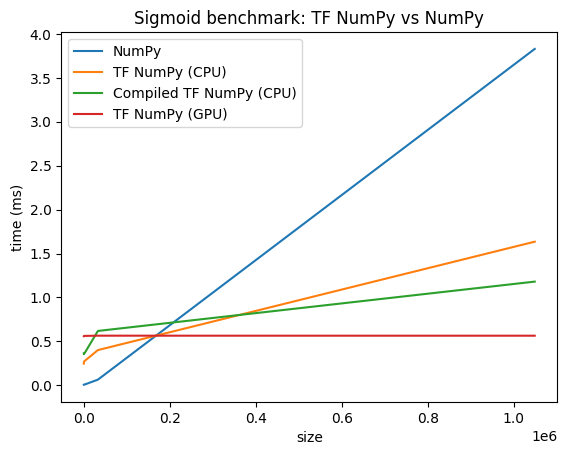

In [26]:
# Define a simple implementation of `sigmoid`, and benchmark it using
# NumPy and TensorFlow NumPy for different input sizes.

def np_sigmoid(y):
  return 1. / (1. + np.exp(-y))

def tnp_sigmoid(y):
  return 1. / (1. + tnp.exp(-y))

@tf.function
def compiled_tnp_sigmoid(y):
  return tnp_sigmoid(y)

sizes = (2 ** 0, 2 ** 5, 2 ** 10, 2 ** 15, 2 ** 20)
np_inputs = [np.random.randn(size).astype(np.float32) for size in sizes]
np_times = benchmark(np_sigmoid, np_inputs)

with tf.device("/device:CPU:0"):
  tnp_inputs = [tnp.random.randn(size).astype(np.float32) for size in sizes]
  tnp_times = benchmark(tnp_sigmoid, tnp_inputs)
  compiled_tnp_times = benchmark(compiled_tnp_sigmoid, tnp_inputs)

has_gpu = len(tf.config.list_logical_devices("GPU"))
if has_gpu:
  with tf.device("/device:GPU:0"):
    tnp_inputs = [tnp.random.randn(size).astype(np.float32) for size in sizes]
    tnp_times_gpu = benchmark(compiled_tnp_sigmoid, tnp_inputs, 100, True)
else:
  tnp_times_gpu = None
plot(np_times, tnp_times, compiled_tnp_times, has_gpu, tnp_times_gpu)

## 参考資料

- TensorFlow NumPy: 分散型画像分類のチュートリアル
- TensorFlow NumPy: Keras と分散ストラテジー
- [Trax と TensorFlow NumPy を使用したセンチメント分析](https://github.com/google/trax/blob/master/trax/tf_numpy_and_keras.ipynb)